# Dynamic tension of a 1D rod: mixed boundary conditions
Now we consider now mixed boundary conditions for the problem
$$ 
\begin{aligned}
\rho A \partial_{tt} q &= \partial_x (EA \partial_x q), \qquad x \in \Omega = [0, L], \quad t \in [0, T_{\mathrm{end}}], \\
q(0) &= 0, \qquad \partial_x q(L) = 0, \\
q(x, 0) &= \psi_1(x),  \qquad  \partial_t q(x, 0) = 0.
\end{aligned}
$$

where $q$ is the displacement, $\rho$ the density, $A$ the cross-sectional area and $E$ the Young's modulus and $\psi_1(x)$ is the first mode for the problem.

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from math import pi
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.plot_config import configure_matplotlib
configure_matplotlib()
from IPython.display import HTML

from src.fem import mass_matrix_lagrange, stiffness_matrix, discrete_gradient
from src.time_integration import newmark, implicit_midpoint
from src.linear_algebra import remove_row_column

## Problem Setup
We define the problem parameters and discretize the domain. The domain is split into two parts of equal size containing the same number of elements.

In [2]:
# Parameters
length = 1  # Length of the domain (m)
cross_section = 1  # Cross section area (m^2)
density = 1  # Density of the fluid (kg/m^3)
young_modulus = 1 # Young modulus (N/m^2)

T_end = 10  # Total time
n_elements = 30  # Number of spatial elements

n_nodes = n_elements + 1
# Derived parameters
mesh_size = length/ n_elements  # Spatial step size
density_unit_length = density * cross_section
axial_stiffness = young_modulus * cross_section
axial_compliance = 1./(young_modulus * cross_section)

# Spatial grid
coordinates = np.linspace(0, length, n_elements+1)

assert n_elements%2==0
n_elements_l = n_elements//2
n_elements_r = n_elements//2
n_nodes_l = n_elements_l + 1
n_nodes_r = n_elements_r + 1

n_dofs_l = n_elements_l + n_nodes_l
n_dofs_r = n_elements_r + n_nodes_r

coordinates_left = np.linspace(0, length/2, n_nodes_l)
coordinates_right = np.linspace(length/2, length, n_nodes_r)

midpoints_left = np.zeros(n_elements_l)

for i in range(len(midpoints_left)):
    midpoints_left[i] = 0.5*(coordinates_left[i] + coordinates_left[i+1])

# Initial conditions
q_0 = lambda x : np.sin(pi/(2*length)* x)  # Initial displacement
v_0 = lambda x : 0*x  # Initial velocity
sigma_0 = lambda x:  pi / (2 * length) * axial_stiffness * np.cos(pi*x/(2*length))

q_0_nodes = q_0(coordinates)
v_0_nodes = v_0(coordinates)
sigma_0_nodes = sigma_0(coordinates)

q_0_nodes_bc = q_0_nodes[1:] 
v_0_nodes_bc = v_0_nodes[1:]

sigma_0_nodes_l = sigma_0(coordinates_left)

q_0_nodes_r = q_0(coordinates_right)
v_0_nodes_r = v_0(coordinates_right)


##  Construction mass, stiffness and discrete derivative matrices

Matrices for the classical discretization

In [3]:
M_full = mass_matrix_lagrange(coordinates, density_unit_length)
K_full = stiffness_matrix(coordinates, axial_stiffness)
D_full = discrete_gradient(coordinates)

sigma_0_dg = axial_stiffness/mesh_size * D_full @ q_0_nodes

Matrices for the interconnection based discretization

In [4]:
M_left = mass_matrix_lagrange(coordinates_left, axial_compliance)
D_left = discrete_gradient(coordinates_left)
B_left = np.zeros((n_dofs_l, 1))
B_left[n_nodes_l - 1] = 1
v_0_dg_l = v_0(midpoints_left)
q_0_dg_l = q_0(midpoints_left)


M_right = mass_matrix_lagrange(coordinates_right, density_unit_length)
D_right = discrete_gradient(coordinates_right)
B_right = np.zeros((n_dofs_r, 1))
B_right[n_elements_r] = 1

sigma_0_dg_r = axial_stiffness/mesh_size * D_right @ q_0_nodes_r

## Choice of the time step

Now the Dirichlet boundary conditions need to be taken into account.

In [5]:
# Stability condition for explicit scheme
wave_speed = np.sqrt(young_modulus/density)

# Time step based on the wave speed
dt_wave = mesh_size / wave_speed

M_full_bc = remove_row_column(M_full, 0, 0)
K_full_bc = remove_row_column(K_full, 0, 0)
eigenvalues, _ = sla.eigs(K_full_bc, M=M_full_bc, k=1, which='LM')

# Time step based on the highest eigenvalue
omega_max = np.sqrt(max(eigenvalues.real))
dt_omega = 2/omega_max

print(f"Time step based on the wave speed: {dt_wave:.3f} [s]")
print(f"Time step based on the max frequency: {dt_omega:.3f} [s]")

time_step = 0.9 * dt_omega

# Temporal grid
n_times = int(np.ceil(T_end/time_step))
time_instants = np.linspace(0, T_end, n_times+1)


Time step based on the wave speed: 0.033 [s]
Time step based on the max frequency: 0.019 [s]


## Simulation using the Lagrangian form

For the canonical disretization it is sufficient to pad the homogeneous boundary condition

In [6]:
# Run the implicit scheme
q_newmark_imp_bc, v_newmark_imp_bc = newmark(q_0_nodes_bc, v_0_nodes_bc, M_full_bc, K_full_bc,\
                            time_step, n_times, gamma=0.5, beta=0.25)

q_newmark_imp = np.hstack((np.zeros((1+n_times, 1)), q_newmark_imp_bc))
v_newmark_imp = np.hstack((np.zeros((1+n_times, 1)), v_newmark_imp_bc))


To express the mixed boundary conditions, we consider an interconnection of two port-Hamiltonian systems of opposite causality.
The left part (l) is described by the dual formulation (Dirichlet bcs)

\begin{equation*}
\begin{aligned}
\mathbf{M}_{\rm l} \dot{\mathbf{x}}_{\rm l} &= \mathbf{J}_{\rm l} {\mathbf{x}}_{\rm l} + \mathbf{B}_{\rm l}
\textcolor{cyan}{u}, \\
\textcolor{red}{y} &= \mathbf{B}_{\rm l}^\top {\mathbf{x}}_{\rm l}.
\end{aligned}
\end{equation*}

The right part (r) is described by the primal formulation (Neumann bcs)

\begin{equation*}
\begin{aligned}
\mathbf{M}_{\rm r} \dot{\mathbf{x}}_{\rm r} &= \mathbf{J}_{\rm r} {\mathbf{x}}_{\rm r} + \mathbf{B}_{\rm r}
\textcolor{red}{u}, \\
\textcolor{cyan}{y} &= \mathbf{B}_{\rm r}^\top {\mathbf{x}}_{\rm r}.
\end{aligned}
\end{equation*}
The interconnection is essentially Newton's third law 
\begin{equation*}
\begin{aligned}
    \textcolor{cyan}{u} &= \textcolor{cyan}{y}, \\ \textcolor{red}{u} &= -\textcolor{red}{y},
\end{aligned} \qquad
\begin{aligned}
&\text{The velocity is the same on both sides}, \\
&\text{The forces are opposite}. \\
\end{aligned}
\end{equation*}

The interconnected system can be written as follows
\begin{equation*}
\begin{aligned}
\begin{bmatrix}
\mathbf{M}_{\rm l}  & 0 \\
0 & \mathbf{M}_{\rm r} 
\end{bmatrix} 
\begin{pmatrix}
\dot{\mathbf{x}}_l \\
\dot{\mathbf{x}}_r \\
\end{pmatrix} = 
\begin{bmatrix}
\mathbf{J}_{\rm l}  & +\mathbf{B}_{\rm l} \mathbf{B}_{\rm r}^\top\\
-\mathbf{B}_{\rm r} \mathbf{B}_{\rm l}^\top & \mathbf{J}_{\rm r} 
\end{bmatrix} 
\begin{pmatrix}
\dot{\mathbf{x}}_l \\
\dot{\mathbf{x}}_r \\
\end{pmatrix}
\end{aligned}.
\end{equation*}

In [7]:
M_mixed_left = sp.block_diag([M_left, density_unit_length * mesh_size *  sp.identity(n_elements_l)])

row1_left = sp.hstack([sp.csr_matrix((n_nodes_l, n_nodes_l)), -D_left.T])
row2_left = sp.hstack([D_left, sp.csr_matrix((n_elements_l, n_elements_l))])
J_mixed_left = sp.vstack([row1_left, row2_left])

M_mixed_right = sp.block_diag([axial_compliance * mesh_size *  sp.identity(n_elements_r), M_right])

row1_right = sp.hstack([sp.csr_matrix((n_elements_r, n_elements_r)), D_right])
row2_right = sp.hstack([-D_right.T, sp.csr_matrix((n_nodes_r, n_nodes_r))])
J_mixed_right = sp.vstack([row1_right, row2_right])

M_mixed = sp.block_diag([M_mixed_left, M_mixed_right])
J_mixed = sp.block_diag([J_mixed_left, J_mixed_right])

J_interconnection = sp.lil_matrix((n_dofs_l + n_dofs_r, n_dofs_l + n_dofs_r))
J_interconnection[:n_dofs_l, n_dofs_l:] = B_left @ B_right.T
J_interconnection[n_dofs_l:, :n_dofs_l] = - B_right @ B_left.T

J_mixed += J_interconnection

We can employ the same integrators as before, but now using the port-Hamiltonian 


In [8]:
x_at_0 = np.concatenate((sigma_0_nodes_l, v_0_dg_l, sigma_0_dg_r, v_0_nodes_r))

x_mix_implicit = implicit_midpoint(x_at_0, M_mixed, J_mixed, time_step, n_times)

s_mixed_l = x_mix_implicit[:, :n_nodes_l]
s_mixed_r = x_mix_implicit[:, n_dofs_l:n_dofs_l + n_elements_r]

v_mixed_l =  x_mix_implicit[:, n_nodes_l:n_dofs_l]
v_mixed_r =  x_mix_implicit[:, n_dofs_l+n_elements_r:]


Reconstruction of the displacement via the trapezoidal rule

In [9]:
q_mixed_l = np.zeros((1 + n_times, n_elements_l))
q_mixed_l[0, :] = q_0_dg_l

q_mixed_r = np.zeros((1 + n_times, n_nodes_r))
q_mixed_r[0, :] = q_0_nodes_r

for ii in range(n_times):
    q_mixed_l[ii+1, :] = q_mixed_l[ii, :] + 0.5*time_step * (v_mixed_l[ii, :] + v_mixed_l[ii+1, :])
    q_mixed_r[ii+1, :] = q_mixed_r[ii, :] + 0.5*time_step * (v_mixed_r[ii, :] + v_mixed_r[ii+1, :])


## Visualization
We set the parameters for the display options

In [10]:
step_animation = 10
interval_frames = time_step * step_animation * 1000

In [11]:
fig, ax = plt.subplots()
line1, = ax.plot(coordinates, q_newmark_imp[0, :], label='Implicit Newmark')
line2, = ax.plot(midpoints_left, q_mixed_l[0, :], label='Mixed left')
line3, = ax.plot(coordinates_right, q_mixed_r[0, :], label='Mixed right')

ax.set_xlim(0, length)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('$x$')
ax.set_ylabel('$q$')
ax.set_title('Displacement')
ax.legend()
ax.grid(True)
plt.close()

def update(ii):
    line1.set_ydata(q_newmark_imp[ii, :])
    line2.set_ydata(q_mixed_l[ii, :])
    line3.set_ydata(q_mixed_r[ii, :])
    ax.set_title(f"Displacement $t= {ii*time_step:.1f}$ [s]")
    return line1, line2, line3


anim = animation.FuncAnimation(fig, update, frames=range(0, n_times, step_animation), \
                               blit=True, interval=interval_frames)

In [12]:
HTML(anim.to_html5_video())

Plot the energy of the two systems. The energy for the mixed discretization accounts for the left and 
\begin{equation*}
H = \frac{1}{2} \mathbf{x}_l^\top \mathbf{M}_l \mathbf{x}_l + \frac{1}{2} \mathbf{x}_r^\top \mathbf{M}_r \mathbf{x}_r.
\end{equation*}

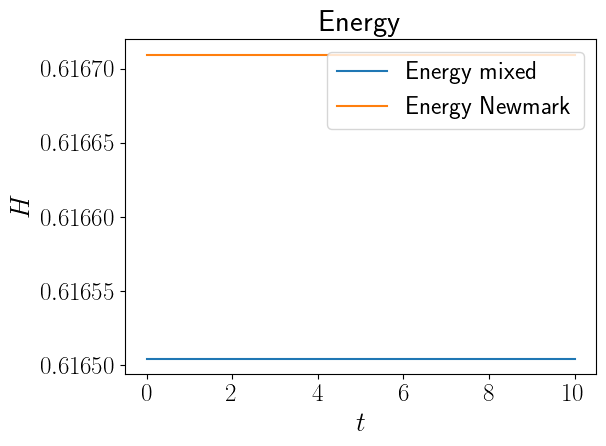

In [13]:
energy_mixed = np.zeros(n_times+1)
energy_newmark = np.zeros(n_times+1)

for ii in range(1+n_times):
    energy_mixed[ii] = 0.5 * np.dot(x_mix_implicit[ii], M_mixed @ x_mix_implicit[ii])
    
    energy_newmark[ii] = 0.5 * np.dot(v_newmark_imp[ii], M_full @ v_newmark_imp[ii]) + \
                          0.5 * np.dot(q_newmark_imp[ii], K_full @ q_newmark_imp[ii])


fig, ax = plt.subplots()
ax.plot(time_instants, energy_mixed, label='Energy mixed')
ax.plot(time_instants, energy_newmark, label='Energy Newmark')
ax.set_xlabel('$t$')
ax.set_ylabel('$H$')
ax.set_title('Energy')
ax.legend()
plt.show()